<a href="https://colab.research.google.com/github/Anonymous1846/Blood-cancer-subtype-classification-using-DCNN/blob/master/DCNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

In [2]:
'''
Problems Statement : Building a set of multiclass classifiers for luekemia prediction using the CNN and pretrained networks.
                     The dataset as of now is obtained from the ALL-IDB1 and ALL-IDB2 and the ASH website.Blood cancer is a 
                     type of cancer that affects blood cells and is caused by DNA mutations. It can be difficult to identify 
                     and is often detected when blood cells begin to behave abnormally. Machine learning algorithms and manual 
                     image processing techniques have been used to extract key information about cancer cells. The proposed 
                     system uses advanced Convolutional Neural Network algorithms and a user-friendly interface to predict the 
                     subtype of cancer,and transfer learning and fine tuning methods are used to improve the performance of the 
                     CNN models.This system can aid in early cancer detection and therapy.
''' 
import keras          #to check version, some APIs may not work in newer versions!
print(keras.__version__)

2.9.0


# **Loading The Dataset From Google Drive.**

In [ ]:
'''
This is an optional block of code which can be executed if the 
google drive needs to be mounted on different account
'''

from google.colab import drive
drive.mount('/content/drive',force_remount=False)

#**The Path To Training, Validation and Testing Datasets**

In [ ]:
import os 
'''
The Images required for the training, validation, and testing is found in the /DCNN Datasets directory !

DCNN Datasets
|
|
|
 ---- Training(80 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
      ----CML
|
|
---- Validation (10 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
      ----CML
|
|
---- Testing (10 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
      ----CML

      The images/dataset is divided into 80% training, 10% testing and 10% validation
'''
training_data_path    = "/content/drive/MyDrive/DCNN Datasets/Training"
validation_data_path  = "/content/drive/MyDrive/DCNN Datasets/Validation"
testing_data_path     = "/content/drive/MyDrive/DCNN Datasets/Testing"

print(f'The Training Images Path   :  {training_data_path}')
print(f'The Validation Images Path :  {validation_data_path}')
print(f'The Testing Images Path    :  {testing_data_path}')


The Training Images Path   :  /content/drive/MyDrive/DCNN Datasets/Training
The Validation Images Path :  /content/drive/MyDrive/DCNN Datasets/Validation
The Testing Images Path    :  /content/drive/MyDrive/DCNN Datasets/Testing


In [18]:
CATEGORIES = 5 #indicating normal, ALL, AML, CLL, CML.

# **Image Preprocessing for Custom and AlexNet models**

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
'''
Image preprocessing and augmentation code for normal and AlexNet models,
here we have manually specified the parameters for manipulating the images
Operations include shearing, flipping(both horizontal and vertical) zooming
and filling of data.
'''
training_images_preprocessed = ImageDataGenerator(rescale=1./255,
                                                  rotation_range=40,
                                                  width_shift_range=0.2,
                                                  height_shift_range=0.2,
                                                  shear_range=0.2,
                                                  zoom_range=0.2,
                                                  horizontal_flip=True,
                                                  vertical_flip=True,
                                                  fill_mode='nearest')

validate_images_preprocessed = ImageDataGenerator(rescale=1./255)

# **Image Pre-Processing For resnet50_base50**

In [7]:
'''
This block is only applicable to Transfer Learning  ResNet50 !
'''

from keras.applications.resnet import preprocess_input
training_images_preprocessed=ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

# **Image Pre-Processing For Inceptionv3**

In [ ]:
'''
This block is only applicable to Transfer Learning InceptionV3 !
'''

from keras.applications.inception_v3 import preprocess_input
training_images_preprocessed=ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

# **Image Pre-Processing For VGG 16**

In [ ]:
'''
This block is only applicable to Transfer Learning  VGG 16 !
'''

from keras.applications.vgg16 import preprocess_input 
training_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

# **Model Dictionary for Storing Image Diemensions**

In [8]:
'''
For the purpose of setting the image diemensions for training the models we have assigned
key-value pairs for model:(width,height) so that the appropriate model gets appropriate
diemensions.
'''

model_dict = {'AlexNet':(227,227),
              'Custom':(300,300),
              'ResNet':(224,224),
              'VGG 16':(224,224),
              'InceptionV3':(139,139)}

architecture ='VGG 16'            #the current model to be trained/tested

# **Applying the Image Augmentation to Datasets !**

In [ ]:
def apply_augmentation(data_directory,processing_mode,flag):
  '''
    The function augments the data, according to the processing mode.
    The processing mode has defined earlier seperately for training and validation set !

    params: training/validation directory,
            the processing mode(different for training and validation dataset), 
            flag for model !

    return: augmented data 
  '''
  data_gen = processing_mode.flow_from_directory(
  data_directory,                               
  target_size = model_dict[flag],               
  batch_size = 128,                             
  class_mode='categorical')
  print(f'Image Shape : {model_dict[flag]}')
  return data_gen


training_images_datagen = apply_augmentation(training_data_path,            
                                             training_images_preprocessed,  
                                             architecture)                  

valid_images_datagen = apply_augmentation(validation_data_path,             
                                          validate_images_preprocessed,
                                          architecture)

test_images_datagen = apply_augmentation(testing_data_path,                 
                                         validate_images_preprocessed,
                                         architecture)

print(training_images_datagen.class_indices)          #class indices may give idea of the indices of corresponding cells


Found 341 images belonging to 5 classes.
Image Shape : (224, 224)
Found 52 images belonging to 5 classes.
Image Shape : (224, 224)
Found 51 images belonging to 5 classes.
Image Shape : (224, 224)
{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Normal': 4}


#**Using the mean pixel we have calculated the number of features !**

In [ ]:
from cv2 import imread

sample_image = imread('/content/drive/MyDrive/DCNN Datasets/Training/CLL/61676-CLL cells with cytoplasmic vacuoles.Jpeg')
print("The diemensions of the cancer cell: {}".format(sample_image.shape))
feature_matrix = np.zeros((sample_image.shape[0], sample_image.shape[1])) # for cancer cell


def show_features(feature_matrix,img):
  '''
    The function will calculate the mean pixels values which are essential in understanding the number of possible 
    values/ features in the image !

    params: fetaure matrix, image

    return: None
  '''
  for i in range(1,img.shape[0]):
    for j in range(1,img.shape[1]):
        feature_matrix[i][j] = ((int(img[i,j,0]) + int(img[i,j,1]) + int(img[i,j,2]))/3) # mean for three channels !

  features = np.reshape(feature_matrix, (img.shape[0]*img.shape[1])) 
  print("The mean pixels values for the cancer cells: {}".format(features.shape[0]))

show_features(feature_matrix,sample_image) # for cancer cell 


The diemensions of the cancer cell: (784, 1000, 3)
The mean pixels values for the cancer cells: 784000


# **Representation of Images.**

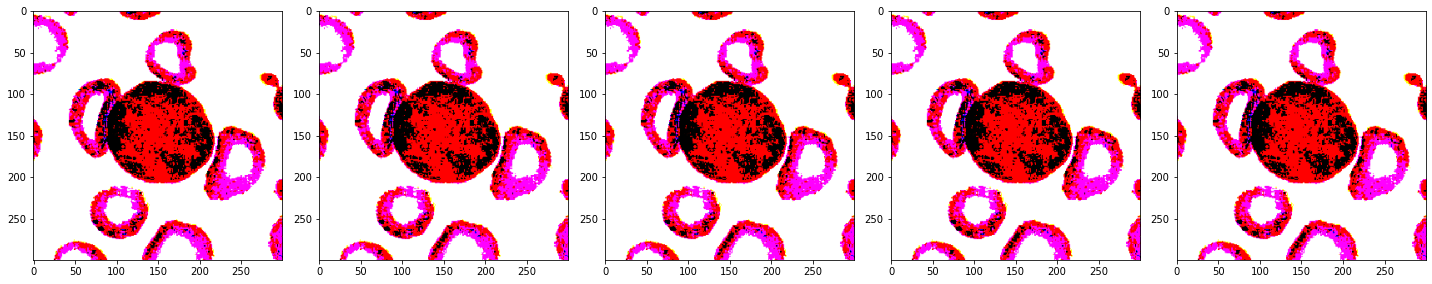

In [ ]:
import matplotlib.pyplot as plt 
def plot(image):
  '''
    The function is used to plot the augmented figures of the images, for visual demonstartion !

    params: image object
    return: None
  '''
  fig,axes=plt.subplots(1,5,figsize=(20,20))    # 20 x 20 images 
  axes=axes.flatten()
  for imag,axis in zip(image,axes):              #iterate through the images matplotlib and cv2
    axis.imshow(imag)
  plt.tight_layout()
  plt.show()

training_images_datagen.class_indices
sample_images=[training_images_datagen[0][0][0] for i in range(5)]
plot(sample_images)

# **Multiclass Test Classifier !**

In [16]:
from keras.layers import MaxPooling2D,Conv2D,Dropout,Dense,Flatten,BatchNormalization,MaxPool2D,AveragePooling2D,GlobalAveragePooling2D
from keras.models import Sequential

In [ ]:
'''
The CNN model is used to predict whether the given data image is of ALL,AML,CLL,CML or Normal type,
it contains 5 convolution and corresponding number of maxpooling layers.
RelU function is added to each layer so that it can introduce non-linearity and 
avoid the negative values !
'''

custom_model  =  Sequential([Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)), 
                          MaxPooling2D(2, 2),
                          Conv2D(32, (3,3), activation='relu'),
                          MaxPooling2D(2,2),                                    
                          Conv2D(64, (3,3), activation='relu'),
                          MaxPooling2D(2,2),                                   
                          Conv2D(64, (3,3), activation='relu'), 
                          MaxPooling2D(2,2),                                   
                          Conv2D(64, (3,3), activation='relu'), 
                          MaxPooling2D(2,2),                                   
                          Flatten(),                                                         
                          Dense(512, activation='relu'),
                          Dense(CATEGORIES, activation='softmax')])       #softmax gives prediction values for cancer cells

custom_model.summary()

# **Multiclass Classifier Based On AlexNet**

In [ ]:
'''
Implementation of the AlexNet architecture, which is an common architecture of the CNN model
The AlexNet Alrchitecture has been modified since, the original one is capable of classifiying
upto 1000 tensors, and requires more computational power !
'''

alexnet_model =Sequential([
                    Conv2D(96, (11, 11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
                    BatchNormalization(),
                    MaxPooling2D((3, 3),strides=(2,2)),
                    Conv2D(256, (5, 5),padding='same', activation='relu'),                    
                    MaxPooling2D((3, 3),strides=(2, 2)),
                    Conv2D(384, (3, 3), padding='same',activation='relu'),
                    Conv2D(384, (3, 3), padding='same',activation='relu'),
                    Conv2D(256, (3, 3), padding='same',activation='relu'),
                    MaxPooling2D((3, 3),strides=(2, 2)),
                    Flatten(),
                    Dense(4096, activation='relu'),                 
                    Dropout(0.5),
                    Dense(4096, activation='relu'),                
                    Dropout(0.5),
                    Dense(CATEGORIES, activation='softmax')])

alexnet_model.summary()

# **Multiclass Classifier Based On VGG 16**

In [ ]:
'''
  VGG-16 is a convolutional neural network model trained on the ImageNet dataset. 
  The model is characterized by its deep architecture, which consists of 16 layers, 
  including 13 convolutional layers and 3 fully connected layers. The convolutional layers 
  are organized into 5 blocks, with each block containing multiple convolutional layers
  and a max pooling layer. The model takes an image as input and classifies it into one 
  of 1000 object categories.The VGG-16 model is widely used as a base model for image 
  classification and object detection tasks.
'''

from keras.applications.vgg16 import VGG16  

# referencing the base model with imagenet weights and removing the top layers for fine-tuning
vgg16_base =  VGG16(weights='imagenet',
              include_top = False,
              input_shape = (224, 224, 3))

trainable = False

for layer in vgg16_base.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    if trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#fine-tuning the vgg16 model to classify the 5 types of cells
vgg16_model = Sequential([vgg16_base,
                          Flatten(),
                          Dropout(0.5),
                          Dense(256,activation='relu'),
                          Dense(CATEGORIES,activation='softmax')])

vgg16_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,138,757
Trainable params: 13,503,493
Non-trainable params: 7,635,264
_____________________________________

# **Multiclass Classifier Based On ResNet50**

In [ ]:
'''
  ResNet50 is a deep convolutional neural network that was trained on more than a million images from the ImageNet database. 
  The network is 50 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.
  It was developed by researchers at Microsoft Research in 2015, and has since become a popular model for image classification tasks 
  due to its high accuracy and efficient use of computational resources. The key innovations in ResNet50 are the use of residual 
  connections and batch normalization, which make it possible to train very deep networks without the problems of vanishing gradients
'''

from keras.applications.resnet import ResNet50   

resnet50_base = ResNet50(weights="imagenet", 
    include_top=False,
    input_shape=(224,224,3)
)

for layer in resnet50_base.layers[:165]:
   layer.trainable = False
for layer in resnet50_base.layers[165:]:
   layer.trainable = True

resnet50_model = Sequential(
                          [resnet50_base,                         
                          Flatten(),
                          Dropout(0.5),
                          Dense(256,activation='relu'),
                          Dropout(0.5),
                          Dense(CATEGORIES, activation='softmax')
                          ])

resnet50_model.summary()

# **Multiclass Classifier Based On InceptionV3**

In [ ]:
'''
  InceptionV3 is a deep convolutional neural network that was trained for image classification on the ImageNet dataset. 
  The network is made up of a series of modules, called Inception modules, which are designed to identify and extract a wide variety of features from 
  an image at multiple scales. The key innovation in InceptionV3 is the use of depthwise separable convolutions, which significantly
  reduce the number of parameters in the model, making it more efficient to run on resource-constrained devices. 
  It also includes a module called the "auxiliary classifier" which gives more informations about image during backpropagation, 
  which enhance its performance. InceptionV3 is widely used in image recognition, and related tasks like object detection and 
  semantic segmentation, Due to its high accuracy, low computation cost and scalable nature
'''

from keras.applications import InceptionV3 

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(299, 299,3))
# base_model.trainable = False
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(CATEGORIES,activation='softmax'))
add_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
base_model.summary()

# **Compile the model**

In [ ]:
'''
Compiling the model using the loss function  crossentropy and RMSProp !

return : None

params : model object 
'''
from tensorflow.keras.optimizers import RMSprop,Adam                              
def compile_model(model):
  model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(lr=1e-5), #optionally use the Adam with learning rate 0.001 - 1e-5
                metrics=['accuracy'])
compile_model(custom_model)


# **The Path To Model H5 Files**

In [ ]:
'''
The below callback list is used to moniter the validation accuracy, and the save the best version of the
CNN model. The paths has been specified for later use !

The Classifier model and the history file are saved in the Binary Classifier Models directory, in the format:

Model_Name_Directory
                | 
                |
                 ---- Model_File.h5
                 ---- Model_History.pickle
                 -----Model_Test_Acc.pickle
'''

model_path    = '/content/drive/MyDrive/DCNN Classifier Models /Test Classifier/Test Classifier_Model.h5'
alexnet_path  = '/content/drive/MyDrive/DCNN Classifier Models /AlexNet Classifier/AlexNet_Classifier_Model.h5'
resnet50_base_path   = '/content/drive/MyDrive/DCNN Classifier Models /resnet50_base Classifier/resnet50_base_Model.h5'
vggnet_path   = '/content/drive/MyDrive/DCNN Classifier Models /VGGNet Classifier/VGGNet_Model.h5'
googlenet_path   = '/content/drive/MyDrive/DCNN Classifier Models /GoogleNet Classifier/GoogleNet_Model.h5'

# **Validation and CallBack Lists**

# Early Stopping To Prevent Overfitting Of The Models

In [ ]:
'''
Early stopping is a mechanism, which allows to moniter a value, specially the val_loss, and stop the 
training, at a particular patience level, to avoid overfitting !
'''
from keras.callbacks import ModelCheckpoint,EarlyStopping 
early_call_back = EarlyStopping(monitor="val_loss",patience=8,verbose=1,mode="auto",restore_best_weights=True)

# Model Check Points To Save The Best Weights

In [ ]:
callback_checkpoint=ModelCheckpoint(model_path,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callback_checkpoint_list=[callback_checkpoint,early_call_back]#can remove the early stopping if needed !

# **Training the datset based on given model !**

In [ ]:
'''
The below function takes in an arguement, which is the model to be trained and it trains the dataset with the specified model
epochs:depending on the early stopping

Params: model object

Return the trained object
'''

def train_the_model(model):
  the_final_train = model.fit(
                      training_images_datagen,
                      callbacks       = callback_checkpoint_list,
                      validation_data = valid_images_datagen,
                      steps_per_epoch = 3, #the steps per epoch is set to 2, but cannot be set to more than 3(because of error !) 
                      epochs          = 80,#100 for regular !
                      verbose         = 2,
                    )
  return the_final_train


trained_model=train_the_model(custom_model)

# **Saving History Pickle File !**

# Path To Store The Respective Model Training And Validation Losses

In [ ]:
model_pickle_path    = '/content/drive/MyDrive/DCNN Classifier Models /Test Classifier/Test Classifier_Model.pickle'
alexnet_pickle_path  = '/content/drive/MyDrive/DCNN Classifier Models /AlexNet Classifier/AlexNet_Classifier_Model.pickle'
resnet50_base_pickle_path   = '/content/drive/MyDrive/DCNN Classifier Models /resnet50_base Classifier/resnet50_base_Model.pickle'
vggnet_pickle_path   = '/content/drive/MyDrive/DCNN Classifier Models /VGGNet Classifier/VGGNet_Model.pickle'
googlenet_pickle_path  = '/content/drive/MyDrive/DCNN Classifier Models /GoogleNet Classifier/GoogleNet_Model.pickle'
# efficientnet_pickle_path   = '/content/drive/MyDrive/DCNN Classifier Models /resnet50_base Classifier/resnet50_base_Model.pickle'

# **Saving the Accuracy and Loss To A Pickle File**

In [ ]:
'''
The model cannot path cannot be directly used to retrieve the history thats
why we are saving the respective model history to a pickle file 

return : None

params : model_history and path of pickle file 
'''
import pickle 
def save_file(pickle_dir,model_history):
  with open(pickle_dir,'wb') as binary_pickle:
    binary_pickle.write(pickle.dumps(model_history)) #dumping to pickle before writing to pickle file !
    print(f'History Saved to {pickle_dir}')

save_file(model_pickle_path,trained_model.history) #the path of the model history pickle and the current model history !

History Saved to /content/drive/MyDrive/DCNN Classifier Models /Test Classifier/Test Classifier_Model.pickle


# **Accuracy and Loss Graph !**

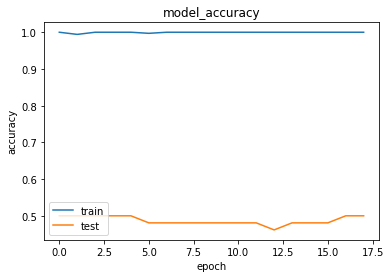

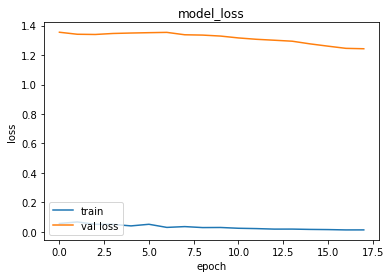

Training Accuracy : 100.0 %
Validation Accuracy : 50.0 %


In [ ]:
'''
The accuracy and the losses at each iteration/epoch is evaluated in the graph below
matplotlib is used for plotting.

return:None

params:model history path
'''
def plot_metrics(acc_path):
  with open(acc_path,'rb') as model_history: #opening the pickle file which contains the dictionary !
    model=model_history.read()
  model=pickle.loads(model)
  plt.plot(model['accuracy'])
  plt.plot(model['val_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower left')
  plt.show()

  plt.plot(model['loss'])
  plt.plot(model['val_loss'])
  plt.title('model_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','val loss'],loc='lower left')
  plt.show()
  train_acc = model['accuracy'][-1]*100
  val_acc   = model['val_accuracy'][-1]*100
  print(f'Training Accuracy : {round(train_acc,2)} %')
  print(f'Validation Accuracy : {round(val_acc,2)} %')

plot_metrics(googlenet_pickle_path)


# **Getting The Prediction Values From The Models**

In [ ]:
import keras.utils as image
def get_preds(model,image_path):
  size = (224,224)      #default set to 224 x 224 for simplicity !
  if model == 'AlexNet':
    model,size = alexnet_path,model_dict['AlexNet']
  elif model == 'Binary':
    model,size = model_path,model_dict['Binary']
  elif model == 'resnet50_base':
    model = resnet50_base_path
  elif model == 'GoogleNet':
    model = googlenet_path
  elif model == 'VGG':
    model = vggnet_path
  else:
    raise Exception('Invalid Model Arguments !')             #exception thrown for invalid path !

  model = keras.models.load_model(model)                     #loading the model.h5 from the drive !
  img   = tf.keras.utils.load_img(image_path, target_size=size)       # loading the image in 300x300 diemensions(227x227x3 for AlexNet)
  img   = image.img_to_array(img)
  img   = np.expand_dims(img, axis=0)                        #expanding along one axis 
  result_vector = model.predict(img).round(1)
  return result_vector[0]

# Obtaining the Prediced values and Actual Values

In [ ]:
y_preds = [get_preds('resnet50_base',x) for x in tests]
y_true = test_images_datagen.classes
class_labels = list(test_images_datagen.class_indices.keys())

#**Testing for Cancer vs Normal**

In [ ]:
'''
The final module of the system which basically predicts whether given cell is a blast or normal cell,
based on the image and the prediction model file ! First of all, the model decides which model to call based
on the falg you give, then the size is set to 300x300,227x277 respectively for Binary and AlexNet and the
default size is 224x244.

return: Blast or Not 
 
params: path to the model and the path to the image !
'''
import numpy as np
def check_for_cancer(model,image_path):                 
  result_vector = get_preds(model,image_path).tolist()  
  c_array = {0:'ALL', 1:'AML', 2:'CLL', 3:'CML', 4:'Normal'}
  index = result_vector.index(max(result_vector))                
  return c_array[index]


model  = 'VGG'
print(f'Prediction Based on the {model} Classifier !')
print(check_for_cancer(model,'/content/drive/MyDrive/DCNN Datasets/Testing/Normal/Im202_0.tif'))


Prediction Based on the VGG Classifier !
1/1 [==============================] - 8s 8s/step
Normal


# Path to store the Test Accuracy

In [ ]:
model_acc_pickle_path    = '/content/drive/MyDrive/DCNN Classifier Models /Test Classifier/Test Classifier_Model.pickle'
alexnet_acc_pickle_path  = '/content/drive/MyDrive/DCNN Classifier Models /AlexNet Classifier/AlexNet_Classifier_Model_Acc.pickle'
resnet50_base_acc_pickle_path   = '/content/drive/MyDrive/DCNN Classifier Models /resnet50_base Classifier/resnet50_base_custom_model.pickle'
vggnet_acc_pickle_path   = '/content/drive/MyDrive/DCNN Classifier Models /VGGNet Classifier/VGGNet_Model_Acc.pickle'
googlenet_acc_pickle_path  = '/content/drive/MyDrive/DCNN Classifier Models /GoogleNet Classifier/GoogleNet_Model_acc.pickle'

# **Save Testing Accuracy To Pickle File**

In [ ]:
'''
The optional block of code only run if the accuracy is to be calculated !

return: None

params: model_path, test_generator, pickle_file path

'''

def get_accuracy(model_path:str,test_datagen,pickle_file:str)->None:
  model = keras.models.load_model(model_path)
  loss,accuracy = model.evaluate(test_datagen,batch_size = 128)
  with open(pickle_file,'wb') as binary_pickle:
    binary_pickle.write(pickle.dumps((loss,accuracy))) #dumping to pickle before writing to pickle file !
    print(f'Accuracy Saved to {pickle_file}')

get_accuracy(model_path,test_images_datagen,model_acc_pickle_path)

# **Retrieve Accuracy From Pickle File**

In [ ]:
'''
The model accuracy is originally stored in the drive folder for the sake of simplicity, we refer the 
pickle file path and fetch accuarcy info of the respective model and print their accuracy

return:None

params:accuracy_path
'''
def show_accuracy(model:str,acc_path:str)->None:
  with open(acc_path,'rb') as pickle_file:
    bin = pickle.loads(pickle_file.read()) 
    
    acc = round((bin[1]),3)*100
    print(f'Accuracy for {model}  : {acc}%')

In [ ]:
show_accuracy('resnet50_base',resnet50_base_acc_pickle_path)

FileNotFoundError: ignored